<a href="https://colab.research.google.com/github/sirbastiano/BBlocks/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.2 MB/s eta 0:00:00


In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [21]:
%ls

Cat03.jpg  sample_data/


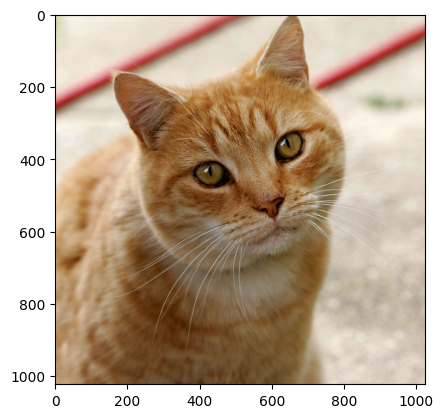

In [22]:
img = Image.open('./Cat03.jpg')

fig = plt.figure()
plt.imshow(img)

In [23]:
# resize to imagenet size
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape

torch.Size([1, 3, 224, 224])

In [24]:
patch_size = 16 # 16 pixels
pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

In [25]:
pathes.shape

torch.Size([1, 196, 768])

In [41]:
print('Batch, Num of patches, Embedding size per patch')
print(1, 224/16 * 224/16, 16*16*3)

Batch, Num of patches, Embedding size per patch
1 196.0 768


In [30]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

Note After checking out the original implementation, I found out that the authors are using a Conv2d layer instead of a Linear one for performance gain. This is obtained by using a kernel_size and stride equal to the `patch_size`. Intuitively, the convolution operation is applied to each patch individually. So, we have to first apply the conv layer and then flat the resulting images.

In [32]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

# CLS Token

Next step is to add the cls token and the position embedding. The cls token is just a number placed in from of each sequence (of projected patches)

In [34]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.proj = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.proj(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        return x

PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

In [35]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x

PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

We added the position embedding in the .positions field and sum it to the patches in the .forward function
Now we need the implement Transformer. In ViT only the Encoder is used, the architecture is visualized in the following picture.

# Multi-Head Attention

So, the attention takes three inputs, the famous queries, keys, and values, and computes the attention matrix using queries and values and use it to “attend” to the values. In this case, we are using multi-head attention meaning that the computation is split across n heads with smaller input size.

## Pros and Cons of Using Multiple Heads in Attention

### Pros

1. **Increased Capacity**: Multiple heads enable the model to attend to different parts of the input simultaneously. This increases the model's ability to capture complex patterns and relationships.

2. **Improved Generalization**: The parallel attention mechanisms can specialize to different types of relationships, potentially leading to better generalization on unseen data.

3. **Modeling Different Relationships**: Different heads can specialize in capturing different types of relationships in the data, such as syntactic vs. semantic in text, or different spatial features in images.

4. **Faster Convergence**: Due to the ability to capture different aspects of the input data, multi-head attention models often converge faster during training.

5. **Reduced Need for Stacked Layers**: The multi-headed approach can sometimes capture complex relationships without requiring as many layers, making the architecture more efficient.

6. **Interpretable Heads**: In some models, individual heads specialize in specific types of relationships, which can offer insights into what the model is learning.

### Cons

1. **Increased Complexity**: Each additional head increases the complexity of the model, which may complicate training, optimization, and deployment. Computational resources are also impacted.

2. **Risk of Overfitting**: More parameters mean a higher risk of overfitting, especially on smaller datasets. This necessitates additional regularization techniques like dropout.

3. **Memory-Intensive**: The increase in the number of parameters raises the memory requirements for both training and inference.

4. **Diminishing Returns**: Beyond a certain number of heads, the benefits may plateau, and performance gains can become marginal.

5. **Increased Hyperparameter Tuning**: The number of heads becomes an additional hyperparameter that needs tuning, complicating the optimization process.

6. **Not Always Beneficial**: For simpler tasks or smaller datasets, multi-head attention may not offer significant benefits over single-head attention, yet still adds to model complexity.

In summary, using multiple heads in attention mechanisms can enrich the model's expressiveness and capacity but also brings challenges such as increased computational complexity and potential for overfitting.


We can use nn.MultiHadAttention from PyTorch or implement our own. For completeness I will show how it looks like:

In [38]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 512, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

V2:

In [39]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        # qkv: Queries, keys, and values.
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        # b: Stands for batch size.
        # h: Stands for the number of attention heads.
        # n: Represents the sequence length (number of tokens in this case).
        # d: The dimension of each attention head's embeddings, which is essentially emb_size // num_heads.
        out = self.projection(out)
        return out

patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

### Understanding `self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size))`

This line of code creates a learnable parameter for positional embeddings in a neural network, often used in Vision Transformers (ViT).

#### Components:

- `nn.Parameter`: This PyTorch class makes the tensor a learnable parameter. During optimization, the values of these parameters will be updated.

- `torch.randn((img_size // patch_size) ** 2 + 1, emb_size)`: Initializes the tensor with random values from a standard normal distribution.

  - `(img_size // patch_size) ** 2`: This expression calculates the number of non-overlapping patches in the image. For example, if the image size (`img_size`) is 224 and the patch size (`patch_size`) is 16, then the number of patches will be $( \left(\frac{224}{16} \right)^2 = 196 )$.
  
  - `+ 1`: This is typically added to account for a "class token", which is an additional, learnable token added to the sequence of image patch embeddings.
  
  - `emb_size`: Specifies the size of the embedding dimension. This dimension should align with the size of the projected image patch embeddings.

#### Result:

The resulting `self.positions` tensor will have the shape \([ ($\text{img_size} // \text{patch_size})^2 + 1, \text{emb_size} ]$). These positional embeddings are typically added to the patch embeddings to give the model spatial (positional) information about each patch in the original image.

In summary, `self.positions` is crucial for the model to include spatial information about image patches, which is vital since transformer architectures natively lack the concept of element order or position in a sequence.


# Residuals
The transformer block has residuals connection


We can create a nice wrapper to perform the residual addition, it will be handy later on

In [42]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

The attention’s output is passed to a fully connected layer composed of two layers that upsample by a factor of expansion the input

In [44]:
# WHAT IS CALLED MLP IN THE TRANSFORMER ENCODER BLOCK:
class FeedForwardBlock(nn.Sequential):
    # subclassing nn.Sequential to avoid writing the forward method
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

# TRANSFORMER ENCODER:

In [48]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [51]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape


torch.Size([1, 197, 768])

you can also PyTorch build-in multi-head attention but it will expect 3 inputs: queries, keys, and values. You can subclass it and pass the same input.

# Transformer Encoder

In ViT only the Encoder part of the original transformer is used. Easily, the encoder is L blocks of TransformerBlock

In [52]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

# Classification Head

In [53]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes))

# ViT


We can compose PatchEmbedding, TransformerEncoder and ClassificationHead to create the final ViT architecture.

In [54]:
class ViT(nn.Sequential):
    def __init__(self,
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [55]:
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19